In [6]:
from xcube.core.dsio import open_cube
from xcube.core.resampling import resample_in_time
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.extract import get_cube_values_for_points

import IPython.display

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

xr.set_options(display_style="html")

import warnings

warnings.filterwarnings("ignore")

---

#### Index

This notebook contains four examples:

1. Inspect the CHL in the cube
2. Create monthly CHL aggregations for specific regions
3. Compute monthly CHL "anomalies" 
4. Compare Cube CHL with In-Situ CHL


#### Installation

For creating an `xcube` Python environment and installing `xcube` follow the instructions given in the [xcube's README](https://github.com/dcs4cop/xcube/blob/main/README.md).

Before using Jupyter Lab for the first time install the `jupyterlab` package and make sure the 
[Jupyter GeoJSON extension](https://www.npmjs.com/package/@jupyterlab/geojson-extension) is installed too:

```bash
(xcube) conda install -c conda-forge jupyterlab
(xcube) jupyter labextension install @jupyterlab/geojson-extension
```


---

## Inspect the CHL in the cube

Open demo data cube with CHL, TSM, and Turbidity for 2017:

In [7]:
cube = open_cube(
    "https://s3.eu-central-1.amazonaws.com/xcube-examples/bc-olci-sns-l2c-2017_1x1024x1024.zarr",
    s3_kwargs=dict(anon=True),
)
cube

<xarray.Dataset>
Dimensions:         (bnds: 2, lat: 5632, lon: 10240, time: 1479)
Coordinates:
  * lat             (lat) float64 62.67 62.66 62.66 62.66 ... 48.01 48.0 48.0
    lat_bnds        (lat, bnds) float64 dask.array<chunksize=(5632, 2), meta=np.ndarray>
  * lon             (lon) float64 -16.0 -16.0 -15.99 ... 10.66 10.66 10.67
    lon_bnds        (lon, bnds) float64 dask.array<chunksize=(10240, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 2017-01-01T09:57:21.976999680 ... 2...
    time_bnds       (time, bnds) datetime64[ns] dask.array<chunksize=(1479, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    chl_c2rcc       (time, lat, lon) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    tsm_c2rcc       (time, lat, lon) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    tur_nechad_665  (time, lat, lon) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes: (12/32)
    acknowledgment:             ESA Sentinel-3 OLCI data, EU HIGHROC project
    comment:                    
    contributor_name:           
    contributor_role:           
    creator_email:              info@brockmann-consult.de
    creator_name:               Brockmann Consult GmbH
    ...                         ...
    publisher_url:              https://www.brockmann-consult.de
    references:                 https://dcs4cop.eu/
    source:                     Sentinel-3 OLCI L2 surface observation
    standard_name_vocabulary:   
    summary:                    
    title:                      DCS4COP Sentinel-3 OLCI L2C Data Cube

Extract a time-series at a point of interes, drop missing values:

In [8]:
chl_ts = (
    cube.chl_c2rcc.sel(lat=53.890319, lon=6.693590, method="nearest")
    .dropna(dim="time")
    .load()
)
chl_ts

<xarray.DataArray 'chl_c2rcc' (time: 40)>
array([ 1.1714654 ,  1.31338298,  2.90247083,  3.04976106,  1.51151323,
        1.50580275,  1.23860836,  4.93053913,  3.87472653,  1.97678614,
        9.30374718,  1.12594032,  5.8912015 ,  5.38629723,  4.17079496,
        3.69425964,  3.04272556,  0.27716073,  0.34839118,  1.02374256,
        0.4744463 ,  0.72768992,  0.37006989,  1.10386074,  0.42149568,
       38.96497726,  0.61831409,  0.7054981 ,  0.42936969,  1.27544093,
        0.62599999,  0.64168257,  0.86150241,  0.48127368,  0.48386189,
        0.37900278,  0.92413759,  1.57427979,  2.40683126,  0.30077615])
Coordinates:
    lat      float64 53.89
    lon      float64 6.694
  * time     (time) datetime64[ns] 2017-02-15T10:29:41.692000256 ... 2017-09-...
Attributes:
    color_table_blue_values:    [128, 255, 255, 255, 255, 0, 0, 0, 0, 0]
    color_table_green_values:   [0, 0, 102, 204, 255, 128, 255, 95, 0, 0]
    color_table_red_values:     [0, 0, 51, 0, 0, 0, 255, 255, 215, 150]
    color_table_sample_values:  [0.0, 0.5, 1.0, 2.0, 3.0, 4.5, 13.0, 25.0, 30...
    long_name:                  Chlorophylll concentration
    original_name:              conc_chl
    sample_frequencies:         [5653, 1366, 704, 637, 485, 620, 493, 378, 29...
    spatial_resampling:         Nearest
    statistics:                 [0.016437947750091553, 109.5191650390625, 3.7...
    units:                      mg m^-3
    valid_pixel_expression:     valid_mask_c2rcc

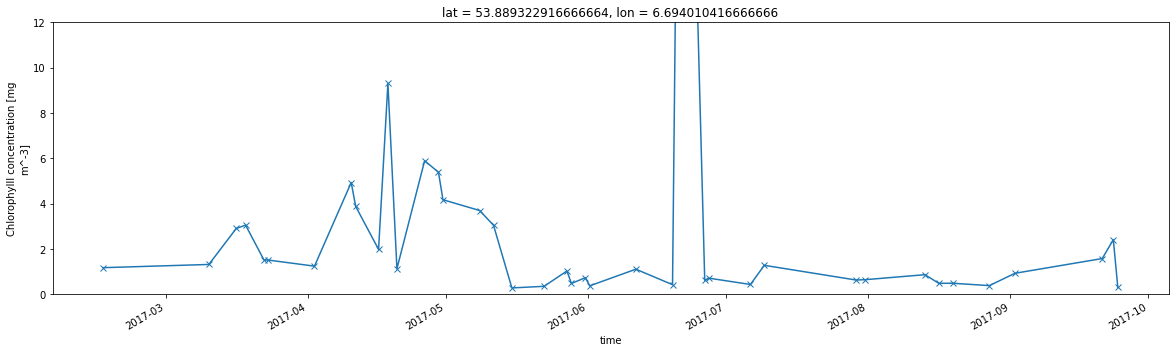

In [9]:
chl_ts.plot.line(marker="x", figsize=(20, 5), ylim=(0, 12))

In [10]:
chl_ts.time

<xarray.DataArray 'time' (time: 40)>
array(['2017-02-15T10:29:41.692000256', '2017-03-10T10:34:27.893000192',
       '2017-03-16T09:39:30.670000128', '2017-03-18T10:25:59.031000064',
       '2017-03-22T10:23:42.891000064', '2017-03-23T09:57:23.911000064',
       '2017-04-02T10:37:20.004000000', '2017-04-10T10:31:29.265999872',
       '2017-04-11T10:03:21.111000064', '2017-04-16T09:35:26.192000000',
       '2017-04-18T10:24:02.340000000', '2017-04-20T09:31:42.156000000',
       '2017-04-26T10:16:34.352999936', '2017-04-29T10:38:56.094000128',
       '2017-04-30T10:12:51.194000128', '2017-05-08T10:05:24.343000064',
       '2017-05-11T10:27:49.249999872', '2017-05-15T10:24:06.260000000',
       '2017-05-22T10:42:44.212999936', '2017-05-27T10:12:55.256999936',
       '2017-05-28T09:46:46.216000000', '2017-05-31T10:09:11.112000000',
       '2017-06-01T09:43:01.190000128', '2017-06-11T10:24:07.256999936',
       '2017-06-19T10:16:39.193999872', '2017-06-21T09:24:18.198000128',
       '2017-06-26T10:35:17.089999872', '2017-06-27T10:09:10.241999872',
       '2017-07-06T09:35:30.111000064', '2017-07-09T09:57:56.212999936',
       '2017-07-29T09:39:13.110000128', '2017-07-31T10:27:47.115000064',
       '2017-08-13T09:50:25.256000000', '2017-08-16T10:12:50.212000000',
       '2017-08-19T10:35:12.175999744', '2017-08-27T10:27:44.174000128',
       '2017-09-02T00:31:39.191999744', '2017-09-21T00:39:01.975000064',
       '2017-09-23T10:25:59.651000064', '2017-09-24T10:01:50.916999936'],
      dtype='datetime64[ns]')
Coordinates:
    lat      float64 53.89
    lon      float64 6.694
  * time     (time) datetime64[ns] 2017-02-15T10:29:41.692000256 ... 2017-09-...
Attributes:
    bounds:         time_bnds
    long_name:      time
    standard_name:  time

Plot the image at one of the times filtered out above:

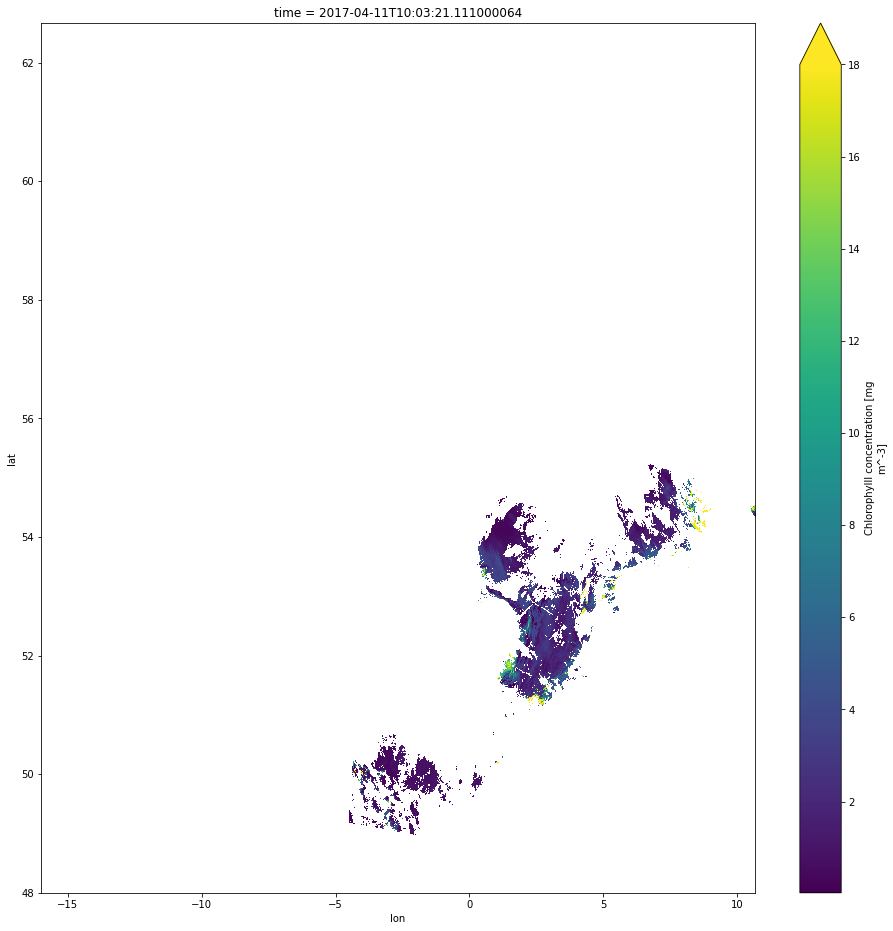

In [11]:
cube.chl_c2rcc.sel(
    time=np.datetime64("2017-04-11 10:00"), method="nearest"
).plot.imshow(vmax=18, figsize=(16, 16))


---

## Create monthly CHL aggregations for specific regions

Read Shapefile with Northsea regions according to Water Framework Directive (WFD):

In [12]:
regions = gpd.read_file("WRRL_Klassen_Nordsee/WRRL_Klassen_Nordsee_latlon3.shp")
regions

TEMPLATE             EU_CD_CW  \
0    Cwbody     DE_CW_N2_4900_01   
1    Cwbody     DE_CW_N4_4900_01   
2    Cwbody     DE_CW_N1_4900_01   
3    Cwbody     DE_CW_N3_4900_01   
4    Cwbody     DE_CW_N1_3100_01   
5    Cwbody     DE_CW_N4_4900_02   
6    Cwbody     DE_CW_NO.3900_01   
7    Cwbody     DE_CW_NO.4000_01   
8    Cwbody     DE_CW_N4_3990_01   
9    Cwbody     DE_CW_N4_3100_01   
10   Cwbody     DE_CW_N2_3100_01   
11   TwBody     DE_TW_T1_3000_01   
12   TwBody     DE_TW_T1_3990_01   
13   TwBody     DE_CW_T1_4900_01   
14   Cwbody     DE_CW_N4_5900_01   
15   Cwbody     DE_CW_N3_5900_01   
16   Cwbody     DE_CW_NO.3990_01   
17   Cwbody     DE_CW_NO_9500_01   
18   Cwbody     DE_CW_N0_5000_01   
19   Cwbody     DE_CW_N5_5000_04   
20   Cwbody     DE_CW_N3_3990_01   
21   TwBody     DE_CW_T1_5000_01   
22   TwBody     DE_CW_T1_5900_01   
23   Cwbody  DE_CW_N1.9500.01.01   
24   Cwbody  DE_CW_N2.9500.01.03   
25   Cwbody  DE_CW_N2.9500.01.04   
26   Cwbody  DE_CW_N2.9500.01.05   
27   Cwbody  DE_CW_N2.9500.01.06   
28   Cwbody  DE_CW_N1.9500.01.02   
29   Cwbody  DE_CW_N4.9500.02.02   
30   Cwbody  DE_CW_N3.9500.02.01   
31   Cwbody  DE_CW_N4.9500.03.02   
32   Cwbody  DE_CW_N3.9500.03.01   
33   Cwbody  DE_CW_N3.5000.04.01   
34   Cwbody  DE_CW_N4.5000.04.02   

                                                 NAME       MS_CD_CW  \
0   Wattenmeer Jadebusen und angrenzende Küstenabs...     N2_4900_01   
1                     Westliches Wattenmeer der Weser     N4_4900_01   
2                Offenes Küstengewässer vor Jadebusen     N1_4900_01   
3                    Offenes Küstengewässer der Weser     N3_4900_01   
4            Euhalines offenes Küstengewässer der Ems     N1_3100_01   
5                      Östliches Wattenmeer der Weser     N4_4900_02   
6                                      Küstenmeer Ems     NO.3900_01   
7                                    Küstenmeer Weser     NO.4000_01   
8                                      Ems Wattenmeer     N4_3990_01   
9                      Polyhalines Wattenmeer der Ems     N4_3100_01   
10                       Euhalines Wattenmeer der Ems     N2_3100_01   
11                          Übergangsgewässer der Ems     T1_3000_01   
12                  Übergangsgewässer des Ems-Ästuars     T1_3990_01   
13                        Übergangsgewässer der Weser     T1_4900_01   
14                     Westliches Wattenmeer der Elbe     N4_5900_01   
15                    Offenes Küstengewässer der Elbe     N3_5900_01   
16                              Küstenmeer Ems-Ästuar     NO.3990_01   
17                                   Küstenmeer Eider     NO_9500_01   
18                                    Küstenmeer Elbe     N0_5000_01   
19                                          Helgoland     N5_5000_04   
20  Polyhalines offenes Küstengewässer des Ems-Äst...     N3_3990_01   
21                         Übergangsgewässer der Elbe     T1_5000_01   
22                         Übergangsgewässer der Elbe     T1_5900_01   
23                                       Vortrapptief  N1.9500.01.01   
24                                  Lister Tidebecken  N2.9500.01.03   
25                                  Hörnum Tidebecken  N2.9500.01.04   
26                                     Aue Tidebecken  N2.9500.01.05   
27                                   Hever Tidebecken  N2.9500.01.06   
28                                         Rummelloch  N1.9500.01.02   
29                                         Außeneider  N4.9500.02.02   
30                                   Eider Tidebecken  N3.9500.02.01   
31                                 Dithmarscher Bucht  N4.9500.03.02   
32                                    Piep Tidebecken  N3.9500.03.01   
33                                     Außenelbe Nord  N3.5000.04.01   
34                                          Hakensand  N4.5000.04.02   

   CHAR_TYPE TY_CW_CD                                           TY_NA_CW  \
0          B     NEA2                

In [13]:
IPython.display.GeoJSON(regions.__geo_interface__)

<IPython.display.GeoJSON object>

The remaining steps can be done in a loop over all regions. However, for this demonstration we just pick a single random region:

In [14]:
# region = regions.loc[regions['NAME'] == 'Küstenmeer Elbe']
# region = regions.loc[regions['NAME'] == 'Küstenmeer Eider']
region = regions.loc[regions["NAME"] == "Küstenmeer Ems"]
region

TEMPLATE          EU_CD_CW            NAME    MS_CD_CW CHAR_TYPE TY_CW_CD  \
6   Cwbody  DE_CW_NO.3900_01  Küstenmeer Ems  NO.3900_01         B       N0   

                             TY_NA_CW    INS_WHEN     INS_BY STATUS_YR  ...  \
6  Küstenmeer jenseits der 1SM-Grenze  2004-06-30  R. Kaiser      2004  ...   

  RISK_ECST RISK_DATE          AREA PERIMETER    HECTARES   KM2  Anz_Sand  \
6         2      None  1.825506e+09  220270.2  182550.589  1826         0   

  Anz_Misch Anz_Schlic                                           geometry  
6         0          0  POLYGON ((7.88315 53.83487, 7.86883 53.83012, ...  

[1 rows x 41 columns]

In [15]:
IPython.display.GeoJSON(region.__geo_interface__)

<IPython.display.GeoJSON object>

Note, this reagion is still a data frame, whose geometry is a one-element series. That's is how we get the actual geometry object: 

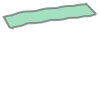

In [16]:
polygon = region.geometry.values[0]
polygon

We'll now narrow down the data cube to that selected region and mask out all values that don't intersect with the region polygon:

In [17]:
cube_masked = mask_dataset_by_geometry(cube, polygon)
cube_masked

<xarray.Dataset>
Dimensions:         (bnds: 2, lat: 146, lon: 546, time: 1479)
Coordinates:
  * lat             (lat) float64 54.0 53.99 53.99 53.99 ... 53.62 53.62 53.62
  * lon             (lon) float64 6.465 6.467 6.47 6.473 ... 7.879 7.882 7.884
  * time            (time) datetime64[ns] 2017-01-01T09:57:21.976999680 ... 2...
    lat_bnds        (lat, bnds) float64 dask.array<chunksize=(146, 2), meta=np.ndarray>
    lon_bnds        (lon, bnds) float64 dask.array<chunksize=(546, 2), meta=np.ndarray>
    time_bnds       (time, bnds) datetime64[ns] dask.array<chunksize=(1479, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    chl_c2rcc       (time, lat, lon) float64 dask.array<chunksize=(1, 146, 546), meta=np.ndarray>
    tsm_c2rcc       (time, lat, lon) float64 dask.array<chunksize=(1, 146, 546), meta=np.ndarray>
    tur_nechad_665  (time, lat, lon) float64 dask.array<chunksize=(1, 146, 546), meta=np.ndarray>
Attributes: (12/32)
    acknowledgment:             ESA Sentinel-3 OLCI data, EU HIGHROC project
    comment:                    
    contributor_name:           
    contributor_role:           
    creator_email:              info@brockmann-consult.de
    creator_name:               Brockmann Consult GmbH
    ...                         ...
    publisher_url:              https://www.brockmann-consult.de
    references:                 https://dcs4cop.eu/
    source:                     Sentinel-3 OLCI L2 surface observation
    standard_name_vocabulary:   
    summary:                    
    title:                      DCS4COP Sentinel-3 OLCI L2C Data Cube

Next, we resample the masked and clipped cube to monthly averages:

In [18]:
cube_1m = resample_in_time(cube_masked, frequency="1M", method="mean")
cube_1m

<xarray.Dataset>
Dimensions:              (bnds: 2, lat: 146, lon: 546, time: 13)
Coordinates:
  * time                 (time) datetime64[ns] 2016-12-31 ... 2017-12-31
  * lat                  (lat) float64 54.0 53.99 53.99 ... 53.62 53.62 53.62
  * lon                  (lon) float64 6.465 6.467 6.47 ... 7.879 7.882 7.884
    lat_bnds             (lat, bnds) float64 dask.array<chunksize=(146, 2), meta=np.ndarray>
    lon_bnds             (lon, bnds) float64 dask.array<chunksize=(546, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    chl_c2rcc_mean       (time, lat, lon) float64 dask.array<chunksize=(1, 146, 546), meta=np.ndarray>
    tsm_c2rcc_mean       (time, lat, lon) float64 dask.array<chunksize=(1, 146, 546), meta=np.ndarray>
    tur_nechad_665_mean  (time, lat, lon) float64 dask.array<chunksize=(1, 146, 546), meta=np.ndarray>
Attributes: (12/34)
    acknowledgment:             ESA Sentinel-3 OLCI data, EU HIGHROC project
    comment:                    
    contributor_name:           
    contributor_role:           
    creator_email:              info@brockmann-consult.de
    creator_name:               Brockmann Consult GmbH
    ...                         ...
    source:                     Sentinel-3 OLCI L2 surface observation
    standard_name_vocabulary:   
    summary:                    
    title:                      DCS4COP Sentinel-3 OLCI L2C Data Cube
    time_coverage_start:        <xarray.DataArray 'time' ()>\narray('2017-01-...
    time_coverage_end:          <xarray.DataArray 'time' ()>\narray('2017-12-...

In [19]:
cube_1m.time

<xarray.DataArray 'time' (time: 13)>
array(['2016-12-31T00:00:00.000000000', '2017-01-31T00:00:00.000000000',
       '2017-02-28T00:00:00.000000000', '2017-03-31T00:00:00.000000000',
       '2017-04-30T00:00:00.000000000', '2017-05-31T00:00:00.000000000',
       '2017-06-30T00:00:00.000000000', '2017-07-31T00:00:00.000000000',
       '2017-08-31T00:00:00.000000000', '2017-09-30T00:00:00.000000000',
       '2017-10-31T00:00:00.000000000', '2017-11-30T00:00:00.000000000',
       '2017-12-31T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-12-31 2017-01-31 ... 2017-12-31

We will frequently use the data `cube_1m` in the following steps, so that we benefit if we load them all into memory:

In [20]:
cube_1m = cube_1m.load()

We are going to work with the CHL values only, therefore:

In [21]:
chl = cube_1m.chl_c2rcc_mean

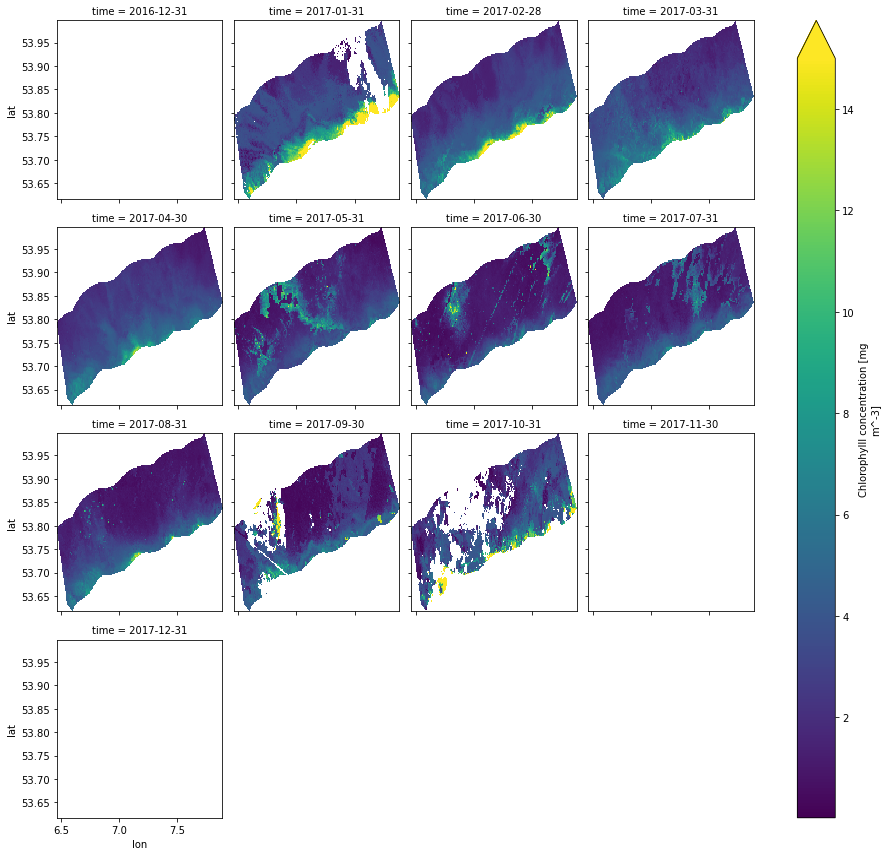

In [22]:
chl.plot.imshow(col="time", col_wrap=4, vmax=15)

Now we can compute time series of the mean, median and the p90 values:

In [23]:
chl_mean = chl.mean(dim=["lat", "lon"])
chl_p50 = chl.median(dim=["lat", "lon"])
chl_p90 = chl.quantile(0.9, dim=["lat", "lon"])

In [24]:
chl_ts_ds = xr.Dataset(dict(chl_mean=chl_mean, chl_p50=chl_p50, chl_p90=chl_p90))
chl_ts_df = chl_ts_ds.to_dataframe().drop("quantile", axis=1)
chl_ts_df

chl_mean   chl_p50   chl_p90
time                                    
2016-12-31       NaN       NaN       NaN
2017-01-31  4.547736  3.609405  9.218224
2017-02-28  3.638575  3.166796  5.873994
2017-03-31  3.674974  3.423619  5.903209
2017-04-30  3.262771  2.890220  5.164213
2017-05-31  2.833770  2.226355  5.466666
2017-06-30  1.991946  1.211070  4.383509
2017-07-31  2.326900  1.612868  4.596536
2017-08-31  2.281199  1.643400  4.686294
2017-09-30  2.620549  2.189837  5.022860
2017-10-31  3.839721  3.330516  6.188496
2017-11-30       NaN       NaN       NaN
2017-12-31       NaN       NaN       NaN

<AxesSubplot:xlabel='time'>

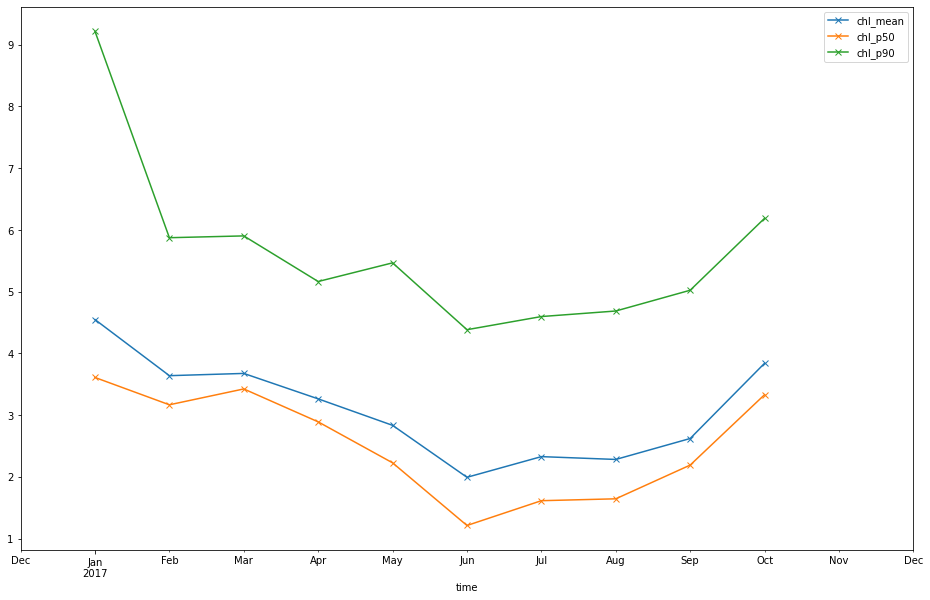

In [25]:
chl_ts_df.plot.line(figsize=(16, 10), marker="x")

---

## Compute monthly CHL "anomalies" 

The following steps explain, how to compute the "anomaly" of every month for the selected region with respect to the mean of all months in 2017:

In [26]:
chl_mean = chl.mean(dim="time")
chl_mean

<xarray.DataArray 'chl_c2rcc_mean' (lat: 146, lon: 546)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 54.0 53.99 53.99 53.99 ... 53.63 53.62 53.62 53.62
  * lon      (lon) float64 6.465 6.467 6.47 6.473 ... 7.876 7.879 7.882 7.884

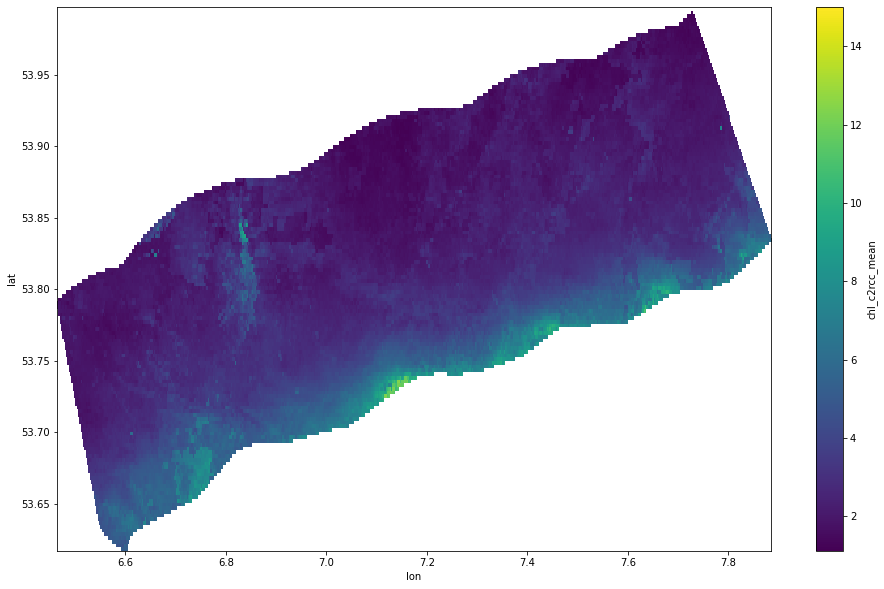

In [27]:
chl_mean.plot.imshow(vmax=15, figsize=(16, 10))

In [28]:
chl_anomaly = chl - chl_mean

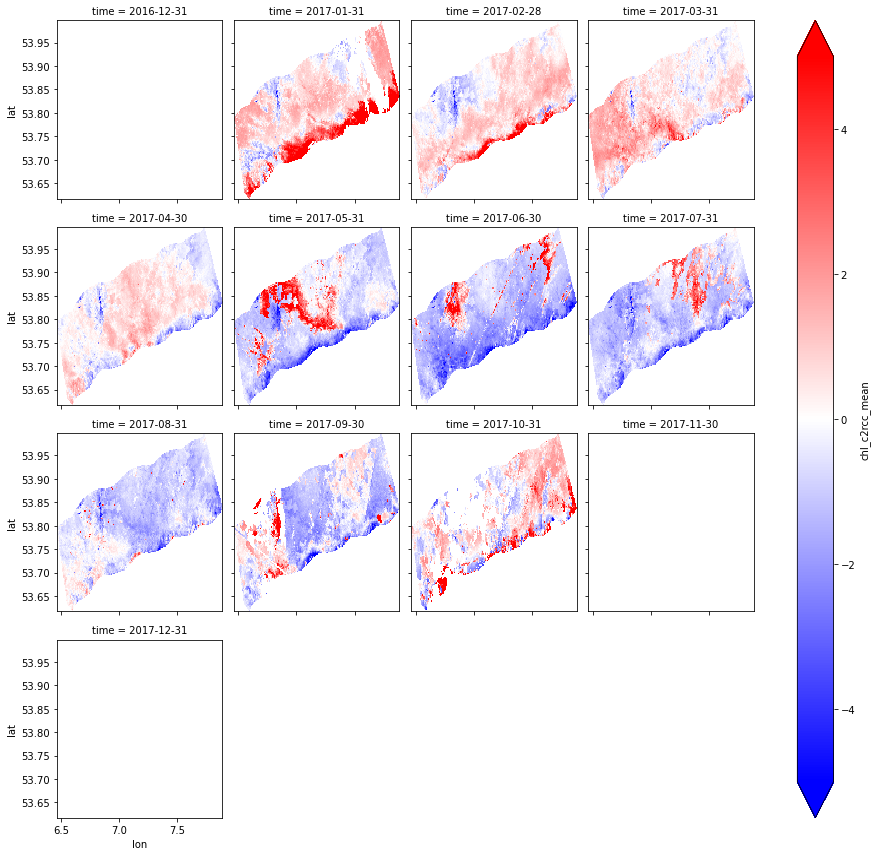

In [29]:
chl_anomaly.plot.imshow(col="time", col_wrap=4, cmap="bwr", vmin=-5, vmax=5)

---

## Compare Cube CHL with In-Situ CHL

The following analysis provided here represents a validation of the cube data with in-situ data.

Read some in-situ data points from a shiptrack made by BSH in Summer 2017: 

In [30]:
cruise = pd.read_csv(
    "./summercruise_2017_positions_for_pixex.txt",
    delimiter="\t",
    converters={"DateTime": np.datetime64},
)
cruise

Name   latitude  longitude            DateTime  \
0   GN003  54.001833   8.111167 2017-08-12 14:57:00   
1   GN008  54.000167   4.830667 2017-08-13 05:03:00   
2   GN009  54.000000   2.999500 2017-08-13 13:12:00   
3   GN011  52.511333   4.325500 2017-08-14 05:10:00   
4   GN012  51.998500   3.730000 2017-08-14 10:21:00   
5   GN013  51.699500   2.857667 2017-08-14 14:03:00   
6   GN014  52.006333   2.007833 2017-08-14 18:51:00   
7   GN016  53.330500   1.671500 2017-08-15 05:23:00   
8   GN017  54.000667   0.996333 2017-08-15 14:10:00   
9   GN018  55.004500  -0.007333 2017-08-16 03:44:00   
10  GN019  55.000333   2.000833 2017-08-16 11:19:00   
11  GN020  55.000333   4.001333 2017-08-16 19:40:00   
12  GN022  54.998667   6.251000 2017-08-17 04:05:00   
13  GN024  55.000000   7.999333 2017-08-17 11:38:00   
14  GN026  56.000833   7.799500 2017-08-17 21:11:00   
15  GN028  55.997167   5.005167 2017-08-18 08:18:00   
16  GN029  56.000500   3.005167 2017-08-18 17:12:00   
17  GN032  55.999667   0.002000 2017-08-19 10:56:00   
18  GN033  55.999000  -0.996000 2017-08-19 15:34:00   
19  GN034  56.999500  -1.003833 2017-08-20 04:12:00   
20  GN035  56.999000   1.330000 2017-08-20 13:03:00   
21  GN036  56.999833   3.500000 2017-08-20 21:16:00   
22  GN038  57.000167   6.003333 2017-08-21 06:43:00   
23  GN039  57.000000   8.000167 2017-08-21 14:08:00   
24  GN040  57.829667   7.997500 2017-08-23 12:34:00   
25  GN041  58.000500   5.993333 2017-08-23 21:45:00   
26  GN043  58.001333   3.002333 2017-08-24 09:03:00   
27  GN044  58.000500   1.500500 2017-08-24 14:14:00   
28  GN056  58.748833  -5.001500 2017-08-25 19:48:00   
29  GN065  59.997167  -5.997333 2017-08-26 16:34:00   
30  GN054  59.999000  -3.001167 2017-08-27 05:59:00   
31  GN053  59.998000  -0.503167 2017-08-27 15:43:00   
32  GN051  60.001833   4.500833 2017-08-28 09:08:00   
33  GN050  59.000000   4.500833 2017-08-28 19:41:00   
34  GN048  59.000167   1.001167 2017-08-29 10:37:00   
35  GN047  59.000500   0.003167 2017-08-29 15:19:00   

    Chlorophyll-a_Jeff_Humphr  Phaeophytin_Jeff_Humphr  Chlorophyll_ges    SD  \
0                       5.939                    1.244            6.560   4.5   
1                       1.319                    0.274            1.456   3.5   
2                       0.415                    0.093            0.461   NaN   
3                       7.216                    1.444            7.938  12.0   
4                       2.642                    0.554            2.919   6.0   
5                       1.715                    0.360            1.895   5.5   
6                       1.933                    0.400            2.133   3.0   
7                       0.666                    0.140            0.736  11.0   
8                       1.677                    0.351            1.852  10.5   
9                       0.937                    0.199            1.037   NaN   
10                      0.484                    0.100            0.534  14.5   
11                      0.480                    0.102            0.532   NaN   
12                      1.126                    0.238            1.245   NaN   
13                      2.790                    0.589            3.085   6.0   
14                      1.851                    0.396            2.049   NaN   
15                      0.582                    0.126            0.645  11.0   
16                      0.348                    0.075            0.386  13.0   
17                      1.230                    0.251            1.356   NaN   
18                      1.165                    0.246            1.288  10.0   
19                      1.436                    0.301            1.587   NaN   
20                      0.540                    0.114            0.597  13.9   
21                      0.712                    0.151            0.787   NaN   
22                      0.481                    0.102            0.532  14.5   
23                      1

Since we want to compare the points with data in the cube, we need to match the names of coordinate variables first, so we rename the columns:

In [31]:
cruise = cruise.rename(
    columns={"longitude": "lon", "latitude": "lat", "DateTime": "time"}
)
cruise["ID"] = np.arange(0, len(cruise))

Where are these points?

In [32]:
from shapely.geometry import Point

cruise_geom = gpd.GeoDataFrame(
    cruise.drop(["lon", "lat"], axis=1),
    crs={"init": "epsg:4326"},
    geometry=[Point(xy) for xy in zip(cruise.lon, cruise.lat)],
)
IPython.display.GeoJSON(cruise_geom.__geo_interface__)

<IPython.display.GeoJSON object>

We now select that month from the cube (no need to do this, this is an optional step for demonstration only):

In [33]:
cube_subset = cube.sel(time="2017-08")
cube_subset

<xarray.Dataset>
Dimensions:         (bnds: 2, lat: 5632, lon: 10240, time: 136)
Coordinates:
  * lat             (lat) float64 62.67 62.66 62.66 62.66 ... 48.01 48.0 48.0
    lat_bnds        (lat, bnds) float64 dask.array<chunksize=(5632, 2), meta=np.ndarray>
  * lon             (lon) float64 -16.0 -16.0 -15.99 ... 10.66 10.66 10.67
    lon_bnds        (lon, bnds) float64 dask.array<chunksize=(10240, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 2017-08-01T09:59:56.478000128 ... 2...
    time_bnds       (time, bnds) datetime64[ns] dask.array<chunksize=(136, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    chl_c2rcc       (time, lat, lon) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    tsm_c2rcc       (time, lat, lon) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    tur_nechad_665  (time, lat, lon) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes: (12/32)
    acknowledgment:             ESA Sentinel-3 OLCI data, EU HIGHROC project
    comment:                    
    contributor_name:           
    contributor_role:           
    creator_email:              info@brockmann-consult.de
    creator_name:               Brockmann Consult GmbH
    ...                         ...
    publisher_url:              https://www.brockmann-consult.de
    references:                 https://dcs4cop.eu/
    source:                     Sentinel-3 OLCI L2 surface observation
    standard_name_vocabulary:   
    summary:                    
    title:                      DCS4COP Sentinel-3 OLCI L2C Data Cube

We now resample that month to weekly averages in order to increase the probability that we find match-ups:

In [34]:
cube_1w = resample_in_time(cube_subset, frequency="1W", method="mean")
cube_1w

<xarray.Dataset>
Dimensions:              (bnds: 2, lat: 5632, lon: 10240, time: 5)
Coordinates:
  * time                 (time) datetime64[ns] 2017-07-30 ... 2017-08-27
  * lat                  (lat) float64 62.67 62.66 62.66 ... 48.01 48.0 48.0
    lat_bnds             (lat, bnds) float64 dask.array<chunksize=(1024, 2), meta=np.ndarray>
  * lon                  (lon) float64 -16.0 -16.0 -15.99 ... 10.66 10.66 10.67
    lon_bnds             (lon, bnds) float64 dask.array<chunksize=(1024, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    chl_c2rcc_mean       (time, lat, lon) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    tsm_c2rcc_mean       (time, lat, lon) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    tur_nechad_665_mean  (time, lat, lon) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes: (12/34)
    acknowledgment:             ESA Sentinel-3 OLCI data, EU HIGHROC project
    comment:                    
    contributor_name:           
    contributor_role:           
    creator_email:              info@brockmann-consult.de
    creator_name:               Brockmann Consult GmbH
    ...                         ...
    source:                     Sentinel-3 OLCI L2 surface observation
    standard_name_vocabulary:   
    summary:                    
    title:                      DCS4COP Sentinel-3 OLCI L2C Data Cube
    time_coverage_start:        <xarray.DataArray 'time' ()>\narray('2017-08-...
    time_coverage_end:          <xarray.DataArray 'time' ()>\narray('2017-08-...

Next, we extract values from the data cube `cube_1w` for all the points in the `cruise`:

In [35]:
match_ups = get_cube_values_for_points(
    cube_1w, cruise, include_coords=True, include_indexes=True
)
match_ups

<xarray.Dataset>
Dimensions:              (idx: 36)
Coordinates:
    time                 (idx) datetime64[ns] 2017-08-13 ... 2017-08-27
    lat                  (idx) float64 54.0 54.0 54.0 52.51 ... 59.0 59.0 59.0
    lon                  (idx) float64 8.111 4.829 2.999 ... 1.001 0.003906
Dimensions without coordinates: idx
Data variables:
    chl_c2rcc_mean       (idx) float64 dask.array<chunksize=(36,), meta=np.ndarray>
    tsm_c2rcc_mean       (idx) float64 dask.array<chunksize=(36,), meta=np.ndarray>
    tur_nechad_665_mean  (idx) float64 dask.array<chunksize=(36,), meta=np.ndarray>
    time_index           (idx) int64 2 2 2 2 2 2 2 2 2 2 ... 4 4 4 4 4 4 4 4 4 4
    lat_index            (idx) int64 3327 3327 3328 3899 ... 1023 1408 1407 1407
    lon_index            (idx) int64 9258 7998 7295 7804 ... 7872 7872 6528 6145

Here are the match-ups for CHL and TUR:

In [36]:
chl_match_ups = match_ups.chl_c2rcc_mean.values
tur_match_ups = match_ups.tur_nechad_665_mean.values

We add them to the cruise data:

In [37]:
cruise["chl_olci"] = chl_match_ups
cruise["tur_olci"] = tur_match_ups / 40
cruise

Name        lat       lon                time  Chlorophyll-a_Jeff_Humphr  \
0   GN003  54.001833  8.111167 2017-08-12 14:57:00                      5.939   
1   GN008  54.000167  4.830667 2017-08-13 05:03:00                      1.319   
2   GN009  54.000000  2.999500 2017-08-13 13:12:00                      0.415   
3   GN011  52.511333  4.325500 2017-08-14 05:10:00                      7.216   
4   GN012  51.998500  3.730000 2017-08-14 10:21:00                      2.642   
5   GN013  51.699500  2.857667 2017-08-14 14:03:00                      1.715   
6   GN014  52.006333  2.007833 2017-08-14 18:51:00                      1.933   
7   GN016  53.330500  1.671500 2017-08-15 05:23:00                      0.666   
8   GN017  54.000667  0.996333 2017-08-15 14:10:00                      1.677   
9   GN018  55.004500 -0.007333 2017-08-16 03:44:00                      0.937   
10  GN019  55.000333  2.000833 2017-08-16 11:19:00                      0.484   
11  GN020  55.000333  4.001333 2017-08-16 19:40:00                      0.480   
12  GN022  54.998667  6.251000 2017-08-17 04:05:00                      1.126   
13  GN024  55.000000  7.999333 2017-08-17 11:38:00                      2.790   
14  GN026  56.000833  7.799500 2017-08-17 21:11:00                      1.851   
15  GN028  55.997167  5.005167 2017-08-18 08:18:00                      0.582   
16  GN029  56.000500  3.005167 2017-08-18 17:12:00                      0.348   
17  GN032  55.999667  0.002000 2017-08-19 10:56:00                      1.230   
18  GN033  55.999000 -0.996000 2017-08-19 15:34:00                      1.165   
19  GN034  56.999500 -1.003833 2017-08-20 04:12:00                      1.436   
20  GN035  56.999000  1.330000 2017-08-20 13:03:00                      0.540   
21  GN036  56.999833  3.500000 2017-08-20 21:16:00                      0.712   
22  GN038  57.000167  6.003333 2017-08-21 06:43:00                      0.481   
23  GN039  57.000000  8.000167 2017-08-21 14:08:00                      1.446   
24  GN040  57.829667  7.997500 2017-08-23 12:34:00                      0.687   
25  GN041  58.000500  5.993333 2017-08-23 21:45:00                      1.389   
26  GN043  58.001333  3.002333 2017-08-24 09:03:00                      0.340   
27  GN044  58.000500  1.500500 2017-08-24 14:14:00                      0.488   
28  GN056  58.748833 -5.001500 2017-08-25 19:48:00                      1.314   
29  GN065  59.997167 -5.997333 2017-08-26 16:34:00                      0.533   
30  GN054  59.999000 -3.001167 2017-08-27 05:59:00                      2.649   
31  GN053  59.998000 -0.503167 2017-08-27 15:43:00                      0.898   
32  GN051  60.001833  4.500833 2017-08-28 09:08:00                      0.609   
33  GN050  59.000000  4.500833 2017-08-28 19:41:00                      1.073   
34  GN048  59.000167  1.001167 2017-08-29 10:37:00                      0.331   
35  GN047  59.000500  0.003167 2017-08-29 15:19:00                      0.366   

    Phaeophytin_Jeff_Humphr  Chlorophyll_ges    SD    TUR  ID  chl_olci  \
0                     1.244            6.560   4.5  1.449   0  4.782143   
1                     0.274            1.456   3.5  0.185   1       NaN   
2                     0.093            0.461   NaN  0.036   2       NaN   
3                     1.444            7.938  12.0  0.061   3       NaN   
4                     0.554            2.919   6.0  0.078   4  1.221753   
5                     0.360            1.895   5.5  0.121   5       NaN   
6                     0.400            2.133   3.0  0.440   6  2.010603   
7                     0.140            0.736  11.0  0.050   7  0.947754   
8                     0.351            1.852  10.5  0.040   8  0.540131   
9                     0.199            1.037   NaN  0.026   9       NaN   
10                    0.100            0.534  14.5  0.018  10  0.395832   
11                    0.102            0.532   NaN  0.029  11  1.288891   
12                    0.238     

<AxesSubplot:xlabel='Chlorophyll_ges', ylabel='chl_olci'>

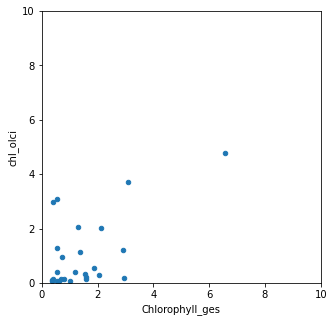

In [38]:
cruise.plot.scatter(
    "Chlorophyll_ges", "chl_olci", xlim=(0, 10), ylim=(0, 10), figsize=(5, 5)
)

<AxesSubplot:xlabel='TUR', ylabel='tur_olci'>

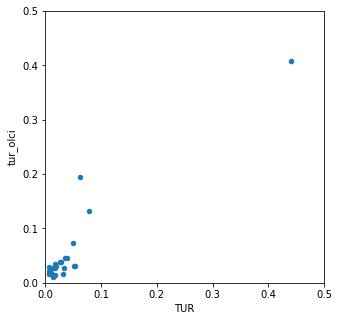

In [39]:
cruise.plot.scatter("TUR", "tur_olci", xlim=(0, 0.5), ylim=(0, 0.5), figsize=(5, 5))